## **this is `01-matmul.ipynb` and `02_fully_connected.ipynb`**

In [1]:
from exp.nb_01 import *

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

# **Some stuff I think I must understand**

___

# **01-matmul.ipynb - Redo**

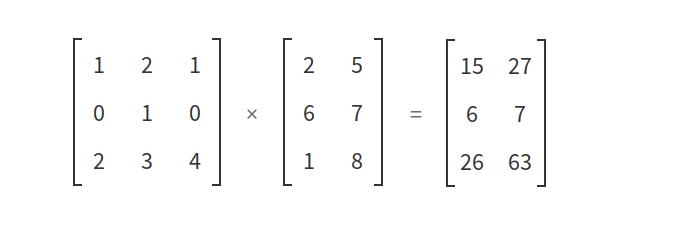

In [3]:
a = torch.tensor([[1,2,1],[0,1,0],[2,3,4]])
b = torch.tensor([[2,5],[6,7],[1,8]])
a,a.shape,b,b.shape

(tensor([[1, 2, 1],
         [0, 1, 0],
         [2, 3, 4]]),
 torch.Size([3, 3]),
 tensor([[2, 5],
         [6, 7],
         [1, 8]]),
 torch.Size([3, 2]))

In [4]:
torch.zeros(3,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

## **This is the most raw way of matrix multiplication**

In [5]:
result=torch.zeros(3,2)
for i in range(3):
    for j in range(2):
        for k in range(3):
            print((i,k),(k,j),(i,j))

(0, 0) (0, 0) (0, 0)
(0, 1) (1, 0) (0, 0)
(0, 2) (2, 0) (0, 0)
(0, 0) (0, 1) (0, 1)
(0, 1) (1, 1) (0, 1)
(0, 2) (2, 1) (0, 1)
(1, 0) (0, 0) (1, 0)
(1, 1) (1, 0) (1, 0)
(1, 2) (2, 0) (1, 0)
(1, 0) (0, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 2) (2, 1) (1, 1)
(2, 0) (0, 0) (2, 0)
(2, 1) (1, 0) (2, 0)
(2, 2) (2, 0) (2, 0)
(2, 0) (0, 1) (2, 1)
(2, 1) (1, 1) (2, 1)
(2, 2) (2, 1) (2, 1)


This is what is going on above:  
`  a     b     r `   
`(i,k),(k,j),(i,j)`

In [6]:
%time
result=torch.zeros(3,2)
for i in range(3):
    for j in range(2):
        for k in range(3):
            result[i,j]+=a[i,k]*b[k,j]   
result            

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

In [7]:
def matmul(a,b):
    result=torch.zeros(3,2)
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                result[i,j]+=a[i,k]*b[k,j]   
    return result     
    

In [8]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

## **Remove the innermost**

In [9]:
def matmul(a,b):
    
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    result=torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):            
            result[i,j]=(a[i,:]*b[:,j]).sum()
    return result     
    

In [10]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

## **Broadcast**

**unsqueeze part changes the dimension for broadcasting**

In [11]:
a[i].shape,a[i].unsqueeze(-1).shape

(torch.Size([3]), torch.Size([3, 1]))

In [12]:
a[0].unsqueeze(1)

tensor([[1],
        [2],
        [1]])

here `a[0].unsqueeze(-1)` makes the shape of the a[0] -> torch.Size([3, 1]) so it broadcasts on m2 according to Broadcasting rules.(second dimension is 1)

*one of them is 1, in which case that dimension is broadcasted to make it the same size*

**this is the first row of the result is below (not yet summed on `dim = 0`**

In [13]:
(a[0].unsqueeze(1)*b)

tensor([[ 2,  5],
        [12, 14],
        [ 1,  8]])

**this is the first row of the result is below after summation `dim = 0`**

In [14]:
(a[0].unsqueeze(1)*b).sum(dim=0)

tensor([15, 27])

In [15]:
def matmul(a,b):    
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    result=torch.zeros(ar, bc)
    for i in range(ar):                   
            result[i]=(a[i].unsqueeze(-1)*b).sum(dim=0)
    return result     
    

In [16]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

# **02_fully_connected.ipynb - Redo**

## **Dataset**

In [17]:
path=Path('mnist.pkl.gz')
with gzip.open(path) as f:
    x=pickle.load(f,encoding='latin-1')

**this is the training set**

In [18]:
x[0][0].shape,x[0][1].shape

((50000, 784), (50000,))

**this is the validation set**

In [19]:
x[1][0].shape,x[1][1].shape

((10000, 784), (10000,))

**this is the test set**

In [20]:
x[2][0].shape

(10000, 784)

## **Get the data**

In [21]:
def get_data():
    path=Path('mnist.pkl.gz')
    with gzip.open(path) as f:
        #(x_train,train_y),(x_valid,valid_y) = f
        ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')
        return map(tensor, (x_train,y_train,x_valid,y_valid))
def normalize(x,m,s):
    return (x-m)/s

In [22]:
x_train,y_train,x_valid,y_valid=get_data()

In [23]:
x_train.mean(),x_train.std()

(tensor(0.1304), tensor(0.3073))

### **Normalize it**
___

In [24]:
train_mean,train_std =x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [25]:
x_train = normalize(x_train,train_mean,train_std)

In [26]:
x_train.mean(),x_train.std()

(tensor(2.1325e-08), tensor(1.))

**now mean is close to 0 and deviation is 1**

In [27]:
x_valid.mean(),x_valid.std()

(tensor(0.1287), tensor(0.3050))

In [28]:
x_valid = normalize(x_valid, train_mean, train_std)

In [29]:
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

**Test the mean. (`x` must be a tensor**)

In [30]:
def test_near_zero(x,tolerance=1e-3):
    assert x.abs()<tolerance,f'near zero{x}'

In [31]:
x_train.mean()

tensor(2.1325e-08)

In [32]:
test_near_zero(x_train.mean(),tolerance=1e-3)

In [33]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

___

### **Create a linear layer and relu activation**

In [34]:
def lin(x,w,b):
    return x@w+b

In [35]:
def relu(x): return x.clamp_min(0.)

In [36]:
# num hidden
nh = 50

1. **Create random weighs for images (28*28)  * (hidden activations)  for the first layer**
2. **for the second layer create weights as the same number hidden activation  * (number of outputs which is one**

### **Normalize the weights with standart xavier init**

In [37]:
w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)

In [38]:
w1.shape, b1.shape, w2.shape,b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

Normally randn is a normal distribution so this is mean and standar deviation.

In [39]:
w1.mean(),w1.std()

(tensor(0.0103), tensor(1.0067))

this is xavier

In [40]:
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.rand(nh,1)/math.sqrt(m)
b2 = torch.zeros(1)

In [41]:
w1.mean(),w1.std()

(tensor(-0.0002), tensor(0.0358))

In [42]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [43]:
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

#### **feed the valid to the linear layer**

In [44]:
t=lin(x_valid,w1,b1)

In [45]:
t.mean(),t.std()

(tensor(-0.0397), tensor(1.0071))

#### **feed the valid to the relu activation layer**

**results are not great**

In [46]:
t = relu(lin(x_valid,w1,b1))
t.mean(),t.std() 

(tensor(0.3758), tensor(0.5854))

### **Normalize the weights with Kaiming init**

Spot the difference `math.sqrt(2./m )` and the result is far better. 

In [47]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.5117), tensor(0.7864))

kaiming is better
___

## **Create the model**

In [48]:
def model(x):
    l1=lin(x,w1,b1)
    l2=relu(l1)
    l3=lin(l2,w2,b2)
    return l3

In [49]:
model(x_valid).shape

torch.Size([10000, 1])

In [50]:
y_valid.shape

torch.Size([10000])

In [51]:
assert model(x_valid).squeeze(-1).shape == y_valid.shape

## **Create a MSE loss**

In [52]:
def mse(output,target):
    return ((output.squeeze(-1)-target).pow(2)).mean()

In [53]:
predictions= model(x_train)

In [54]:
loss=mse(predictions,y_train)
loss

tensor(24.3061)

## **Calculate gradients for bacward pass**

**Mse gradient**

only thing is why  `inp-targ` instead of `targ-inp` the result is same but for a different loss it may change. Is this a rule?

In [55]:
def mse_grad(inp,targ):
    inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1)/inp.shape[0]

**I have no idea how `w.g`. and `b.g`was calculated**

This could be the answer:  Read this understand what is going on below.<br>[The Matrix Calculus You Need For Deep Learning](https://explained.ai/matrix-calculus/index.html)

In [56]:
def lin_grad(inp,out,w,b):
    inp.g= out.g @ w.t()
    print(f'inp (unsqueezed) shape: {inp.unsqueeze(-1).shape} out.g shape: {out.g.shape}')
    w.g = (inp.unsqueeze(-1)*out.g.unsqueeze(1).sum(0))
    b.g = (out.g.sum(0))
    

In [57]:
def relu_grad(inp,out):
    #print((inp>0).float().shape)
    inp.g = (inp>0).float() * out.g

In [60]:
def forward_and_backward(inp,targ):
    l1 = inp @ w1 +b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    
    mse_grad(out,targ)
    print(out.g.shape)
    lin_grad(l2,out,w2,b2)
    relu_grad(l1,l2)
    lin_grad(inp,l1,w1,b1)

### **Forward & Backward  and check the results with the PyTorch**

In [61]:
forward_and_backward(x_train, y_train)

torch.Size([50000, 1])
inp (unsqueezed) shape: torch.Size([50000, 50, 1]) out.g shape: torch.Size([50000, 1])
inp (unsqueezed) shape: torch.Size([50000, 784, 1]) out.g shape: torch.Size([50000, 50])


**these are clones of our weights and biases**

In [60]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()

clone training set and all weight and bisases `requires_grad_` is a trick. look at `_` at the end. Normal requires_grad throws error.

In [61]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [62]:
test_near(w2g, w2.g)

## Refactor model

**Put Everything in a respective class**

In [63]:
x= torch.randn(3,3)

In [64]:
x

tensor([[-1.8900,  1.4404, -0.0367],
        [-2.7768, -1.7904, -0.6495],
        [-1.5550, -0.1749, -0.8517]])

In [65]:
x=x.clamp_min(0)
x

tensor([[0.0000, 1.4404, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [66]:
class Relu():
    def __call__(self,inp):
        self.inp=inp
        self.out= inp.clamp_min(0)-0.5
        return self.out
    def backward(self):
        self.inp.g = (self.inp>0).float() * self.out.g
        
        

In [67]:
class Lin():
    def __init__(self,w,b):
        self.w=w
        self.b=b
    def __call__(self,inp):
        self.inp=inp
        self.out= inp @ self.w + self.b
        return self.out
    def backward(self):
        self.inp.g= self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        #This is the same
        #self.w.g =(self.inp.unsqueeze(-1)*self.out.g.unsqueeze(1).sum(0))
        self.b.g = (self.out.g.sum(0))
        

In [68]:
class Mse():
    def __call__(self,inp,targ):
        self.inp=inp
        self.targ=targ
        return (self.inp.squeeze()-self.targ).pow(2).mean()
    def backward(self):
        self.inp.g = 2*(self.inp.squeeze()-self.targ).unsqueeze(-1)/self.targ.shape[0]

`Relu()` does not take an argument below, because we are initialize it not calling.

In [69]:
class Model():
    def __init__(self, w1,b1,w2,b2):
        self.layers = [Lin(w1,b1),Relu(),Lin(w2,b2)]
        self.loss= Mse()
    def __call__(self,x,targ):
        for l in self.layers: x = l(x)
        return self.loss(x,targ)
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):l.backward()
        
        

In [70]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [71]:
%time loss = model(x_train, y_train)

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 29.1 ms


In [72]:
%time model.backward()

CPU times: user 362 ms, sys: 93.1 ms, total: 455 ms
Wall time: 75.8 ms


**did not write it (below) just tried to understand. Try next time.**

In [73]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g
    
# self.w.g = inp.t() @ out.g is more readable
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)
        
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [74]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [75]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [76]:
%time loss = model(x_train, y_train)

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 23.4 ms


In [77]:
%time model.backward()

CPU times: user 396 ms, sys: 120 ms, total: 516 ms
Wall time: 86.3 ms


## **What I am not good at:**
- **I have no idea how `w.g`. and `b.g`was calculated**  
This could be the answer:  Read this understand what is going on below.<br>[The Matrix Calculus You Need For Deep Learning](https://explained.ai/matrix-calculus/index.html)
- Python skill for writing the Module Class